In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Read File - Change file path to where you have the cleaned data
file_path = 'C:/Users/jlewa/001 - School/ECO481/cleaned.csv'
hmda = pd.read_csv(file_path)

In [ ]:
# Set up data for machine learning
# Create function that creates stratified samples of a dataset
def stratified_sample(df, col, sample_size, rs=313):
    """Creates a new dataframe that has the same proportions of specified column as the original dataframe"""
    sample = pd.DataFrame()
    total_obs = df.shape[0]
    grouped = df.groupby(col)
    for category in list(grouped.groups.keys()):
        group = grouped.get_group(category)
        group_size = group.shape[0]
        group_sample_size = round((group_size / total_obs) * sample_size)
        if sample.shape[0] > 0:
            sample = pd.concat([sample, group.sample(n=group_sample_size, random_state=rs)], ignore_index=True)
        else:
            sample = grouped.get_group(category).sample(n=group_sample_size, random_state=rs)
    return sample

# Function that collects all data for a specific year
def set_year(df, year):
    """Creates a new dataframe that contains all observations for a specific year"""
    year_data = df[df['as_of_year'] == year]
    return year_data

# Function that splits data into training and test sets
def split_xy(df, y_col):
    """Splits a dataframe into X and y components. The function assumes that the last column is the y variable."""
    X = df.drop(columns=[y_col])
    y = df[y_col]
    return [X, y]

# Create sample function that only draws from specified values in a column
def value_sample(df, col, value, sample_size, rs=313):
    """Creates a dataframe that has a randome sample of observations that have specified value in
    specified column. For example, if col = 'applicant_race_1' and value = 5 (which corresponds to white), 
    the sample will only have observations where the applicant is white.""" 
    sample = df[df[col] == value].sample(sample_size, random_state=rs)
    return sample

# Function that create training data for white model and all race model, and test data for each race
def model_samples(df, year_sample_size, test_sample_size, remove_race=True):
    """Fucntion that creates our training and test data for our ML models. If remove_race is true, the models will be 
    blind to the races of each essential_features = ['as_of_year', 'applicant_race_1', 'co_applicant_race_1', 'action_taken']

selected_features = ['loan_amount_000s', 'purchaser_type', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income']

hmda_selected = hmda[essential_features + selected_features]application."""
    # First collect equal sized samples from each year
    data_by_year = []
    for year in range(2007, 2018):
        year_dataset = set_year(df, year)
        # Create training data for white and all race models
        white_train = value_sample(year_dataset, 'applicant_race_1', 5, year_sample_size, 100)
        all_train = stratified_sample(year_dataset, 'applicant_race_1', year_sample_size, 200)
        if remove_race:
            white_train = white_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            all_train = all_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
        
        # Remove all values from year_dataset that are in white_train and all_train
        #year_dataset = year_dataset.drop(white_train.index)
        #year_dataset = year_dataset.drop(all_train.index)      
        # Create test data for each race
        race_tests = []
        for race in range(1, 6):
            race_sample = value_sample(year_dataset, 'applicant_race_1', race, test_sample_size, 300)
            if remove_race:
                race_sample = race_sample.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            race_tests.append(race_sample)
        data_by_year.append([white_train, all_train, race_tests])
    # Complied the data for each year
    year_data = data_by_year.pop(0) 
    compiled_white = year_data[0]
    compiled_all_race = year_data[1]
    compiled_race_tests = year_data[2]
    while len(data_by_year) > 0:
        year_data = data_by_year.pop(0)
        compiled_white = pd.concat([compiled_white, year_data[0]], ignore_index=True)
        compiled_all_race = pd.concat([compiled_all_race, year_data[1]], ignore_index=True)
        for i in range(0, 5):
            compiled_race_tests[i] = pd.concat([compiled_race_tests[i], year_data[2][i]], ignore_index=True)
    return [compiled_white, compiled_all_race, compiled_race_tests]

def model_testing(model, sample_data, y_col, cv=5, param_grid=None):
    """Fits white model and all race based on the specified training data. The y_col is the y variable column name.
    The sample_data parameter is the output of the model_samples function and param_grid is the hyperparameter grid
    that will be used in the GridSearchCV function. This function will return the results of the each model with given 
    parameters and the testing results from each race."""
    # Create the white model dataset
    X_white, y_white = split_xy(sample_data[0], y_col)
    # Create the all race model dataset
    X_all, y_all = split_xy(sample_data[1], y_col)

    # Set up Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)
    # Define scoring metrics
    scoring = {'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy'}

    # Initialize GridSearchCV for White Only Model
    white_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
    white_search.fit(X_white, y_white)
    # Initialize GridSearchCV for All Races Model
    all_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
    all_search.fit(X_all, y_all)

    # Extract results for each model
    white_results = pd.DataFrame(white_search.cv_results_)
    all_results = pd.DataFrame(all_search.cv_results_)
    
    # Add model type to results
    white_results['Model'] = 'White only'
    all_results['Model'] = 'All races'
    # Combine results
    combined_results = pd.concat([white_results, all_results])

    # Sort combined results by index then drop
    combined_results = combined_results.sort_index()

    # Select relevant columns and rename them for clarity
    relevant_columns = [f'param_{param}' for param in param_grid.keys()] + [
        'mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'Model']
    combined_results = combined_results[relevant_columns]

    # Rename columns for final output
    column_mapping = {f'param_{param}': param for param in param_grid.keys()}
    column_mapping.update({
        'mean_test_roc_auc': 'ROC-AUC Score',
        'mean_test_precision': 'Precision',
        'mean_test_recall': 'Recall',
        'mean_test_accuracy': 'Accuracy'})
    combined_results.rename(columns=column_mapping, inplace=True)

    # Order the columns of so that Model is first
    column_order = ['Model'] + [param for param in param_grid.keys()] + ['ROC-AUC Score', 'Precision', 'Recall', 'Accuracy']
    combined_results = combined_results[column_order]

    return combined_results

def race_tests(model, sample_data, y_col, cv=5, param_grid=None):
    """Function that tests each race sample against the specified model. The y_col is the y variable column name."""
    race_strings = ['American Indian', 'Asian', 'Black', 'Hawaiian/Other', 'White']
    # Create the white model dataset
    X_white, y_white = split_xy(sample_data[0], y_col)
    # Create the all race model dataset
    X_all, y_all = split_xy(sample_data[1], y_col)

    # Set up Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)
    models = []
    race = []
    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    confusion_mats = []

    # Initialize GridSearchCV for White Only Model
    white_search = GridSearchCV(model, param_grid=param_grid, cv=stratified_kfold)
    white_model = white_search.fit(X_white, y_white)
    for i in range(0, 5):
        X_test, y_test = split_xy(sample_data[2][i], y_col)
        white_preds = white_model.predict(X_test)
        white_results = classification_report(y_test, white_preds, output_dict=True)
        models.append('White Only')
        race.append(race_strings[i])
        accuracy.append(white_results['accuracy'])
        precision.append(white_results['1']['precision'])
        recall.append(white_results['1']['recall'])
        roc_auc.append(white_results['1']['f1-score'])
        confusion_mats.append(confusion_matrix(y_test, white_preds))

    # Initialize GridSearchCV for All Races Model
    all_search = GridSearchCV(model, param_grid=param_grid, cv=stratified_kfold)
    all_race_model = all_search.fit(X_all, y_all)
    for i in range(0, 5):
        X_test, y_test = split_xy(sample_data[2][i], y_col)
        all_race_preds = all_race_model.predict(X_test)
        all_race_results = classification_report(y_test, all_race_preds, output_dict=True)
        models.append('All Races')
        race.append(race_strings[i])
        accuracy.append(all_race_results['accuracy'])
        precision.append(all_race_results['1']['precision'])
        recall.append(all_race_results['1']['recall'])
        roc_auc.append(all_race_results['1']['f1-score'])        
        confusion_mats.append(confusion_matrix(y_test, all_race_preds))
    
    results = pd.DataFrame({'Model': models, 'Race': race, 'Accuracy': accuracy,
                             'Precision': precision, 'Recall': recall, 'ROC-AUC': roc_auc,
                               'Confusion Matrix': confusion_mats})
    
    # Sort results by race
    results = results.sort_values(['Race'])
    return results

In [105]:
def by_state_samples_5(df, state_sample_size, remove_race=True):
    
    states = sorted(df['state_code'].unique())
    
    # Lists to store DataFrames for the "All Races" and "White" data for each state
    all_race_dfs = []  # Will store lists of DataFrames, each list corresponding to a state
    white_data_dfs = []  # Will store lists of DataFrames, each list corresponding to a state
    
    # Loop through each state
    for state in states:
        # Filter the dataframe for the current state
        state_data = df[df['state_code'] == state]

        # Get number of observations with 'applicant_race_1' = 5 in the state
        white_sample_size = state_data['applicant_race_1'].value_counts().get(5, 0)
        sample_size = min(state_sample_size, len(state_data))

        # Sample the "White" race (assuming 'White' corresponds to value 5 in the ethnicity column)
        white_sample = value_sample(state_data, 'applicant_race_1', 5, white_sample_size)

        # Sample "All Races" (a random sample from the entire state's data, excluding specific race samples)
        all_sample = stratified_sample(state_data, 'applicant_race_1', sample_size)

        if remove_race:
            white_sample = white_sample.drop(columns=['co_applicant_race_1', 'applicant_race_1'])
            all_sample = all_sample.drop(columns=['co_applicant_race_1', 'applicant_race_1'])
        
        # # Add the state code to each sample to identify which state they belong to
        # white_sample['state_code'] = state
        # all_sample['state_code'] = state

        # Append to the lists
        all_race_dfs.append(all_sample)  
        white_data_dfs.append(white_sample) 
    
    return [all_race_dfs, white_data_dfs]

def model_testing5(model, sample_data, y_col, cv=5, param_grid = None):

    race_strings = ['American Indian', 'Asian', 'Black', 'Hawaiian/Other', 'White']
    # List to store results for each state and dataset
    all_results = []  

    # Set up Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)

    # Define scoring metrics
    scoring = {'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy'}

    # Loop through each state
    models = []
    race = []
    state = []
    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    confusion_mats = []
    i = 0
    for i in range(len(sample_data[1])):

        stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)
        
        # Split the data into features (X) and target (y) for both datasets
        X_all_race, y_all_race = split_xy(sample_data[0][i], y_col)
        X_white, y_white = split_xy(sample_data[1][i], y_col)

        # Initialize GridSearchCV for "All Races" model
        all_race_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
        all_race_search.fit(X_all_race, y_all_race)
        
        # Initialize GridSearchCV for "White" model
        white_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
        white_search.fit(X_white, y_white)

          # Predict the test data for each race

        for j in range(0, 5):
            X_test, y_test = split_xy(sample_data[2][j], y_col)
            white_preds = white_search.predict(X_test)
            white_results = classification_report(y_test, white_preds, output_dict=True)
            all_race_preds = all_race_search.predict(X_test)
            all_race_results = classification_report(y_test, all_race_preds, output_dict=True)
            # Add results to thier respective lists
            models.append('White Only')
            models.append('All Races')
            race.append(race_strings[j])
            race.append(race_strings[j])
            state.append(sample_data[0][i]['state_code'].max())
            state.append(sample_data[1][i]['state_code'].max())
            accuracy.append(white_results['accuracy'])
            accuracy.append(all_race_results['accuracy'])
            precision.append(white_results['1']['precision'])
            precision.append(all_race_results['1']['precision'])
            recall.append(white_results['1']['recall'])
            recall.append(all_race_results['1']['recall'])
            roc_auc.append(white_results['1']['f1-score'])
            roc_auc.append(all_race_results['1']['f1-score'])
            # Add confusion matrices values to list
            confusion_mats.append(confusion_matrix(y_test, white_preds))
            confusion_mats.append(confusion_matrix(y_test, all_race_preds))
        
    return pd.DataFrame({'Model': models, 'Race': race, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'ROC-AUC': roc_auc,
                          'Confusion Matrix': confusion_mats, 'State': state })

In [ ]:
all_feats = ['as_of_year', 'action_taken', 'loan_type', 'loan_purpose',
       'loan_amount_000s', 'msamd', 'state_code', 'county_code',
       'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
       'applicant_income_000s', 'purchaser_type', 'hoepa_status', 'population', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']

hmda_selected = hmda[all_feats]

grouped = hmda_selected.groupby('action_taken')

taken = model_samples(grouped.get_group(1), 20000, 100)
no = model_samples(grouped.get_group(0), 20000, 100)

merged_white = pd.concat([taken[0], no[0]], ignore_index=True)
merged_all = pd.concat([taken[1], no[1]], ignore_index=True)

# Collect test samples for each, Sample = 1 since we do not care about this training data
samples = model_samples(hmda_selected, 1, 5000)


# Model Selection

## Tuning Logistic Regression

In [ ]:
# Logistic Regression Hyperparameters
logit = LogisticRegression(random_state=313)
paramsLG = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [500, 1000]}

from sklearn.preprocessing import StandardScaler

def scale_logit(model_sample_results, feature_scale=[]):
    """Function that scales datasets so that a logistic regression model can be fit."""
    dfs = []
    dfs.append(model_sample_results[0])
    dfs.append(model_sample_results[1])
    for i in range(0, 5):
        dfs.append(model_sample_results[2][i])
    scaled_dfs = []
    # Initialize StandardScaler
    scaler = StandardScaler()
    # Scale all columns that are not object types
    for df in dfs:
        scaled_df = df.copy()
        for col in df.columns:
            # Check if column is not is list of essential features
            essential_features = ['as_of_year', 'action_taken', 'applicant_ethnicity',
                                'co_applicant_ethnicity', 'applicant_race_1',
                                'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex']
            if (df[col].dtype == 'int64' or df[col].dtype == 'float64') and col not in essential_features:
                scaled_df[col] = scaler.fit_transform(df[[col]])
            # Check if column is in list of features to scale
            if col in feature_scale:
                # square root transformation
                scaled_df[col] = df[col] ** (1/3)
        scaled_dfs.append(scaled_df)
    tests = scaled_dfs[2:]
    res = scaled_dfs[:2]
    res.append(tests)
    return res

logit_samples = [merged_white, merged_all, samples[2]]

logit_samples = scale_logit(logit_samples)

logit_models = model_testing(logit, logit_samples, 'action_taken', param_grid=paramsLG, cv=3)
logit_models

## Tuning Random Forest

In [ ]:
rforest = RandomForestClassifier(random_state=313)

paramsRF = {'n_estimators': [100, 250, 500], 'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5],  'bootstrap': [True], 'max_samples':[100, 1000, 5000]}

rforest_samples = [merged_white, merged_all, samples[2]]
random_models = model_testing(rforest, rforest_samples, 'action_taken', param_grid=paramsRF, cv=3)
random_models

## Tuning Bayes Classifier

In [ ]:
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

nb_model = GaussianNB()

results_nb = model_testing(nb_model, samples, y_col='action_taken', cv=3, param_grid=param_grid_nb)
results_nb

# By State

In [ ]:
grouped = hmda_selected.groupby('action_taken')

approved = grouped.get_group(1)
denied = grouped.get_group(0)

states_app = by_state_samples_5(approved, 5000)
states_den = by_state_samples_5(denied, 5000)

# Merge/zip dataframe of states_app and states_den
white_app, white_den = states_app[1], states_den[1]
all_app, all_den = states_app[0], states_den[0]

white_states = []
all_states = []
for i in range(0, len(white_app)):
    white_states.append(pd.concat([white_app[i], white_den[i]], ignore_index=True))
    all_states.append(pd.concat([all_app[i], all_den[i]], ignore_index=True))

samples_1 = model_samples(hmda_selected, 20, 2000)

In [ ]:
paramsRF = {'n_estimators': [500], 'max_depth': [10],
            'min_samples_split': [2],  'bootstrap': [True], 'max_samples':[5000]}

rfor_samples = [white_states, all_states, samples_1[2]]

results_by_state = model_testing5(RandomForestClassifier(random_state=313), rfor_samples, 'action_taken', cv=3, param_grid=paramsRF)
results_by_state

In [ ]:
states_grouped = results_by_state.groupby('state_code')


In [ ]:
import geopandas as gpd

# Create geopandas dataframe for map of US states
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Determine how states are labeled in the geopandas dataframe
# Merge our data with the geopandas dataframe
# Create new dataframes by race to map each
# Plot merged dataframes with column = 'False Positive difference'

# Redundant code for Jack

In [ ]:
# Logistic Regression Hyperparameters
logit = LogisticRegression(random_state=313)
paramsLG = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [500, 1000]}

from sklearn.preprocessing import StandardScaler

def scale_logit(model_sample_results, feature_scale=[]):
    """Function that scales datasets so that a logistic regression model can be fit."""
    dfs = []
    dfs.append(model_sample_results[0])
    dfs.append(model_sample_results[1])
    for i in range(0, 5):
        dfs.append(model_sample_results[2][i])
    scaled_dfs = []
    # Initialize StandardScaler
    scaler = StandardScaler()
    # Scale all columns that are not object types
    for df in dfs:
        scaled_df = df.copy()
        for col in df.columns:
            # Check if column is not is list of essential features
            essential_features = ['as_of_year', 'action_taken', 'applicant_ethnicity',
                                'co_applicant_ethnicity', 'applicant_race_1',
                                'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex']
            if (df[col].dtype == 'int64' or df[col].dtype == 'float64') and col not in essential_features:
                scaled_df[col] = scaler.fit_transform(df[[col]])
            # Check if column is in list of features to scale
            if col in feature_scale:
                # square root transformation
                scaled_df[col] = df[col] ** (1/3)
        scaled_dfs.append(scaled_df)
    tests = scaled_dfs[2:]
    res = scaled_dfs[:2]
    res.append(tests)
    return res

logit_samples = [merged_white, merged_all, samples[2]]

logit_samples = scale_logit(logit_samples)

model_testing(logit, logit_samples, 'action_taken', param_grid=paramsLG, cv=3)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

,Model,C,penalty,solver,max_iter,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,0.1,l1,liblinear,500,0.856711,0.942480,0.579968,0.772286
0,All races,0.1,l1,liblinear,500,0.861126,0.949187,0.591796,0.780057
1,White only,0.1,l2,liblinear,500,0.856726,0.942399,0.579923,0.772239
1,All races,0.1,l2,liblinear,500,0.861149,0.949276,0.591705,0.780043
2,White only,0.1,l1,liblinear,1000,0.856711,0.942480,0.579968,0.772286
2,All races,0.1,l1,liblinear,1000,0.861136,0.949180,0.591792,0.780052
3,White only,0.1,l2,liblinear,1000,0.856726,0.942399,0.579923,0.772239
3,All races,0.1,l2,liblinear,1000,0.861149,0.949276,0.591705,0.780043
4,White only,1,l1,liblinear,500,0.856954,0.942569,0.580550,0.772589
4,All races,1,l1,liblinear,500,0.861144,0.948971,0.592037,0.780100


In [32]:
rforest = RandomForestClassifier(random_state=313)

paramsRF = {'n_estimators': [100, 250, 500], 'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5],  'bootstrap': [True], 'max_samples':[100, 1000, 5000]}

In [ ]:
rforest = RandomForestClassifier(random_state=313)

paramsRF = {'n_estimators': [100, 250, 500], 'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5],  'bootstrap': [True], 'max_samples':[100, 1000, 5000]}

rforest_samples = [merged_white, merged_all, samples[2]]
random = model_testing(rforest, rforest_samples, 'action_taken', param_grid=paramsRF, cv=3)

In [34]:
paramsLG = {'C': [1], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [5000, 10000]}

logit_samples = [merged_white, merged_all, samples[2]]

logit_samples = scale_logit(logit_samples)

model_testing(logit, logit_samples, 'action_taken', param_grid=paramsLG, cv=3)

,Model,C,penalty,solver,max_iter,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,1,l2,liblinear,5000,0.857091,0.942589,0.580686,0.772659
0,All races,1,l2,liblinear,5000,0.861547,0.949158,0.592224,0.780250
1,White only,1,l2,liblinear,10000,0.857091,0.942589,0.580686,0.772659
1,All races,1,l2,liblinear,10000,0.861547,0.949158,0.592224,0.780250


In [45]:
# Feature Selection
# Remove features that did not get selected from the dataset
essential_features = ['as_of_year', 'applicant_race_1', 'co_applicant_race_1', 'action_taken']

selected_features = ['loan_amount_000s', 'purchaser_type', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income']

hmda_selected = hmda[essential_features + selected_features]

# Adjust sample and test sizes for models and testing 
samples = model_samples(hmda_selected, 50000, 5000)

<BarContainer object of 6 artists>

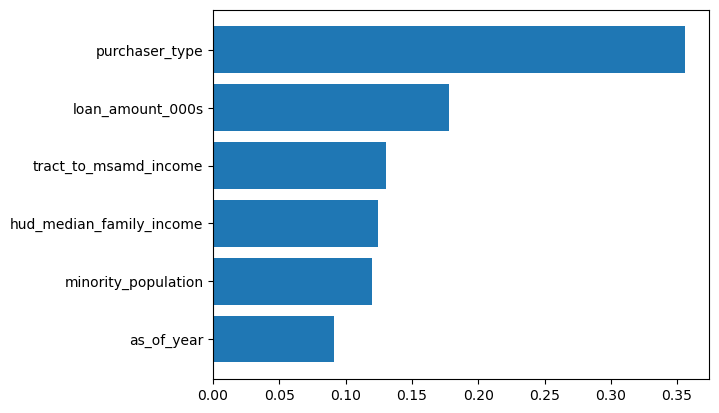

In [39]:
# Run simple random forest model
rforest = RandomForestClassifier(random_state=313)

paramsRF = {'n_estimators': [100, 250, 500], 'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5],  'bootstrap': [True], 'max_samples':[100, 1000, 5000]}

rforest_samples = [samples[0], samples[1], samples[2]]

# Fit simple random forest model

training_data = samples[1]

X_train, y_train = split_xy(merged_white, 'action_taken')

rforest = RandomForestClassifier(random_state=313, n_estimators=50, max_depth=10, min_samples_split=5, bootstrap=True, max_samples=150)

rforest.fit(X_train, y_train)

# Feature Importance
feature_names = X_train.columns

snames, simportances = zip(*sorted(zip(feature_names, rforest.feature_importances_), 
                                   key=lambda pair: pair[1]))
plt.barh(snames, simportances)



In [41]:
# Logistic Regression Hyperparameters
logit = LogisticRegression(random_state=313)

paramsLG = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': [500, 1000, 5000]}

logit_samples = [merged_white, merged_all, samples[2]]

logit_samples = scale_logit(logit_samples, ['purchaser_type'])

logit_late = model_testing(logit, logit_samples, 'action_taken', param_grid=paramsLG, cv=3)
logit_late

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

,Model,C,penalty,solver,max_iter,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,0.1,l1,liblinear,500,0.856947,0.942826,0.580100,0.772461
0,All races,0.1,l1,liblinear,500,0.861371,0.949371,0.591851,0.780143
1,White only,0.1,l2,liblinear,500,0.856992,0.942890,0.580182,0.772520
1,All races,0.1,l2,liblinear,500,0.861425,0.949269,0.591874,0.780120
2,White only,0.1,l1,liblinear,1000,0.856948,0.942818,0.580091,0.772455
2,All races,0.1,l1,liblinear,1000,0.861372,0.949357,0.591855,0.780141
3,All races,0.1,l2,liblinear,1000,0.861425,0.949269,0.591874,0.780120
3,White only,0.1,l2,liblinear,1000,0.856992,0.942890,0.580182,0.772520
4,All races,0.1,l1,liblinear,5000,0.861378,0.949335,0.591842,0.780127
4,White only,0.1,l1,liblinear,5000,0.856956,0.942807,0.580123,0.772466


In [54]:
paramsLG = {'C': [1], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [5000]}

logit_samples = [merged_white, merged_all, samples[2]]

logit_samples1 = scale_logit(logit_samples, ['purchaser_type'])

race_tests(LogisticRegression(random_state=313), logit_samples1, 'action_taken', param_grid=paramsLG, cv=3)

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.796600,0.308587,0.760292,0.438995,"[[39436, 9807], [1380, 4377]]"
5,All Races,American Indian,0.825364,0.344488,0.740316,0.470186,"[[41133, 8110], [1495, 4262]]"
1,White Only,Asian,0.836727,0.315129,0.752569,0.444238,"[[42431, 7800], [1180, 3589]]"
6,All Races,Asian,0.846945,0.330137,0.743552,0.457253,"[[43036, 7195], [1223, 3546]]"
2,White Only,Black,0.807636,0.407941,0.806730,0.541872,"[[38163, 9081], [1499, 6257]]"
7,All Races,Black,0.845382,0.471420,0.795384,0.591978,"[[40327, 6917], [1587, 6169]]"
3,White Only,Hawaiian/Other,0.852036,0.400464,0.801203,0.534013,"[[42199, 6981], [1157, 4663]]"
8,All Races,Hawaiian/Other,0.860145,0.415948,0.795876,0.546355,"[[42676, 6504], [1188, 4632]]"
4,White Only,White,0.851909,0.537978,0.750960,0.626873,"[[40013, 5876], [2269, 6842]]"
9,All Races,White,0.859436,0.556912,0.741082,0.635931,"[[40517, 5372], [2359, 6752]]"


In [78]:
rforest_samples = [merged_white, merged_all, samples[2]]

paramsRF = {'n_estimators': [500], 'max_depth': [10],
            'min_samples_split': [2],  'bootstrap': [True], 'max_samples':[5000]}

random_final = model_testing(rforest, rforest_samples, 'action_taken', param_grid=paramsRF, cv=3)
random_final

,Model,n_estimators,max_depth,min_samples_split,bootstrap,max_samples,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,500,10,2,True,5000,0.917588,0.888074,0.764050,0.833877
0,All races,500,10,2,True,5000,0.920264,0.897789,0.758502,0.836066


In [70]:
paramsRF = {'n_estimators': [500], 'max_depth': [10],
            'min_samples_split': [2],  'bootstrap': [True], 'max_samples':[5000]}

rfor_samples = [merged_white, merged_all, samples[2]]

rf_tested = race_tests(RandomForestClassifier(random_state=313), rfor_samples, 'action_taken',
            cv= 3, param_grid=paramsRF)

"the percent of applicants from race X would have been approved if they were white"
rf_mess = rf_tested.copy()

rf_tested

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.891509,0.487530,0.713045,0.579107,"[[44928, 4315], [1652, 4105]]"
5,All Races,American Indian,0.891255,0.486705,0.712176,0.578238,"[[44919, 4324], [1657, 4100]]"
1,White Only,Asian,0.936309,0.619841,0.686517,0.651477,"[[48223, 2008], [1495, 3274]]"
6,All Races,Asian,0.939145,0.639741,0.682533,0.660444,"[[48398, 1833], [1514, 3255]]"
2,White Only,Black,0.914164,0.667809,0.778623,0.718971,"[[44240, 3004], [1717, 6039]]"
7,All Races,Black,0.919945,0.693569,0.774497,0.731802,"[[44590, 2654], [1749, 6007]]"
3,White Only,Hawaiian/Other,0.934000,0.665608,0.756186,0.708012,"[[46969, 2211], [1419, 4401]]"
8,All Races,Hawaiian/Other,0.934218,0.666667,0.756701,0.708836,"[[46978, 2202], [1416, 4404]]"
4,White Only,White,0.880891,0.612006,0.767644,0.681046,"[[41455, 4434], [2117, 6994]]"
9,All Races,White,0.879236,0.606800,0.769839,0.678665,"[[41344, 4545], [2097, 7014]]"


In [77]:
rf_mess2 = rf_mess.copy()

def false_positive_difference(df):
    # Extract CF results
    true_neg = []
    false_pos = []
    false_neg = []
    true_pos = []
    for i in range(0, len(df)):
        cf = df['Confusion Matrix'].iloc[i]
        true_neg.append(cf[0][0])
        false_pos.append(cf[0][1])
        false_neg.append(cf[1][0])
        true_pos.append(cf[1][1])
    
    df['True Neg'] = true_neg
    df['False Pos'] = false_pos
    df['False Neg'] = false_neg
    df['True Pos'] = true_pos

    # Group by race
    df['False Positive Rate'] = df['False Pos'] / (df['False Pos'] + df['True Neg'])
    
    results = []

    grouped = df.groupby('Race')
    for group in grouped.groups.keys():
        rows = grouped.get_group(group)
        # Get false positive rate for white model
        white_fpr = rows[rows['Model'] == 'White Only']['False Positive Rate'].values[0]
        all_fpr = rows[rows['Model'] == 'All Races']['False Positive Rate'].values[0]
        results.append([group, white_fpr - all_fpr])
    
    return results

false_positive_difference(rf_mess2)

[['American Indian', -0.00018276709380013467],
 ['Asian', 0.0034839043618482626],
 ['Black', 0.007408348150029637],
 ['Hawaiian/Other', 0.00018300122000813185],
 ['White', -0.002418880341694088]]

In [ ]:
hmda['applicant_race_1'].value_counts()

In [17]:
# Remove features that did not get selected from the dataset
all_features = ['as_of_year', 'action_taken', 'loan_type', 'loan_purpose',
       'loan_amount_000s', 'msamd', 'state_code', 'county_code',
       'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
       'applicant_income_000s', 'purchaser_type', 'hoepa_status',
       'population', 'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units']

essential_features = ['as_of_year', 'applicant_race_1', 'co_applicant_race_1', 'action_taken']

selected_features = ['loan_amount_000s', 'purchaser_type', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income']

hmda_selected = hmda[all_features]

# Adjust sample and test sizes for models and testing 
samples = model_samples(hmda_selected, 50000, 5000)

# Random Forest Hyperparameters
rforest = RandomForestClassifier(random_state=313)

paramsRF = {'n_estimators': [100, 250, 500], 'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5],  'bootstrap': [True], 'max_samples':[100, 1000, 5000]}

# Logistic Regression Hyperparameters
logit = LogisticRegression(random_state=313)
paramsLG = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': [500, 1000]}

#random = model_testing(rforest, samples, 'action_taken', param_grid=paramsRF, cv=3)

# Model Tuning
model_testing(logit, samples, 'action_taken', param_grid=paramsLG, cv=3)

KeyboardInterrupt: 

In [12]:
random

,Model,n_estimators,max_depth,min_samples_split,bootstrap,max_samples,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,100,3,2,True,100,0.864126,1.000000,0.413615,0.903055
0,All races,100,3,2,True,100,0.869834,1.000000,0.450656,0.914407
1,White only,250,3,2,True,100,0.868579,1.000000,0.425371,0.904998
1,All races,250,3,2,True,100,0.870571,1.000000,0.439092,0.912605
2,White only,500,3,2,True,100,0.868242,1.000000,0.459595,0.910656
...,...,...,...,...,...,...,...,...,...,...
69,White only,100,20,5,True,5000,0.913090,0.999559,0.573188,0.929395
70,All races,250,20,5,True,5000,0.918636,0.999960,0.590116,0.936133
70,White only,250,20,5,True,5000,0.916252,0.999962,0.573155,0.929427
71,White only,500,20,5,True,5000,0.917378,0.999981,0.573232,0.929442


In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_logit(model_sample_results, feature_scale=[]):
    """Function that scales datasets so that a logistic regression model can be fit."""
    dfs = []
    dfs.append(model_sample_results[0])
    dfs.append(model_sample_results[1])
    for i in range(0, 5):
        dfs.append(model_sample_results[2][i])
    scaled_dfs = []
    # Initialize StandardScaler
    scaler = StandardScaler()
    # Scale all columns that are not object types
    for df in dfs:
        scaled_df = df.copy()
        for col in df.columns:
            # Check if column is not is list of essential features
            essential_features = ['as_of_year', 'action_taken', 'applicant_ethnicity',
                                'co_applicant_ethnicity', 'applicant_race_1',
                                'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex']
            if (df[col].dtype == 'int64' or df[col].dtype == 'float64') and col not in essential_features:
                scaled_df[col] = scaler.fit_transform(df[[col]])
            # Check if column is in list of features to scale
            if col in feature_scale:
                # square root transformation
                scaled_df[col] = df[col] ** (1/3)
        scaled_dfs.append(scaled_df)
    tests = scaled_dfs[2:]
    res = scaled_dfs[:2]
    res.append(tests)
    return res

# Logistic Regression Hyperparameters
logit = LogisticRegression(random_state=313)
paramsLG = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': [500, 1000]}
# paramsLG = {'C': [1], 'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': [500]}

logit_samples = scale_logit(samples)

model_testing(logit, logit_samples, 'action_taken', param_grid=paramsLG, cv=3)


In [66]:
hmda['action_taken'].value_counts()

action_taken
0    20675811
1     4190847
Name: count, dtype: int64

In [15]:
# Model Testing
# Example usage, only put in one hyperparameter imput for each model 
# race_tests(RandomForestClassifier(random_state=313), samples, 'action_taken',
#             cv= 3, param_grid={'n_estimators': [100], 'max_depth': [3], 'bootstrap': [True], 'max_samples':[100]})

race_tests(LogisticRegression(random_state=313), samples, 'action_taken',
            cv= 3, param_grid={'C': [1], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [500]})

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.925545,0.998201,0.289213,0.448485,"[[49240, 3], [4092, 1665]]"
5,All Races,American Indian,0.938782,0.998748,0.415668,0.587023,"[[49240, 3], [3364, 2393]]"
1,White Only,Asian,0.945255,0.999432,0.368840,0.538827,"[[50230, 1], [3010, 1759]]"
6,All Races,Asian,0.955127,0.999566,0.482701,0.651018,"[[50230, 1], [2467, 2302]]"
2,White Only,Black,0.918836,0.999393,0.424703,0.596091,"[[47242, 2], [4462, 3294]]"
7,All Races,Black,0.939945,0.999551,0.574394,0.729550,"[[47242, 2], [3301, 4455]]"
3,White Only,Hawaiian/Other,0.936655,0.999145,0.401718,0.573039,"[[49178, 2], [3482, 2338]]"
8,All Races,Hawaiian/Other,0.951909,0.999685,0.545704,0.706013,"[[49179, 1], [2644, 3176]]"
4,White Only,White,0.892727,0.999067,0.352760,0.521415,"[[45886, 3], [5897, 3214]]"
9,All Races,White,0.914109,0.999317,0.481835,0.650178,"[[45886, 3], [4721, 4390]]"


In [19]:
race_tests(RandomForestClassifier(random_state=313), samples, 'action_taken',
            cv= 3, param_grid={'n_estimators': [500], 'max_depth': [3],
            'min_samples_split': [5],  'bootstrap': [True], 'max_samples':[5000]})

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.947927,1.0,0.502519,0.668902,"[[49243, 0], [2864, 2893]]"
5,All Races,American Indian,0.947927,1.0,0.502519,0.668902,"[[49243, 0], [2864, 2893]]"
1,White Only,Asian,0.965764,1.0,0.605158,0.754017,"[[50231, 0], [1883, 2886]]"
6,All Races,Asian,0.965764,1.0,0.605158,0.754017,"[[50231, 0], [1883, 2886]]"
2,White Only,Black,0.956709,1.0,0.693012,0.818673,"[[47244, 0], [2381, 5375]]"
7,All Races,Black,0.956709,1.0,0.693012,0.818673,"[[47244, 0], [2381, 5375]]"
3,White Only,Hawaiian/Other,0.964455,1.0,0.664089,0.798141,"[[49180, 0], [1955, 3865]]"
8,All Races,Hawaiian/Other,0.964455,1.0,0.664089,0.798141,"[[49180, 0], [1955, 3865]]"
4,White Only,White,0.928527,1.0,0.568544,0.724932,"[[45889, 0], [3931, 5180]]"
9,All Races,White,0.928527,1.0,0.568544,0.724932,"[[45889, 0], [3931, 5180]]"


In [20]:
race_tests(RandomForestClassifier(random_state=313), samples, 'action_taken',
            cv= 3, param_grid={'n_estimators': [100], 'max_depth': [3],
            'min_samples_split': [2],  'bootstrap': [True], 'max_samples':[100]})

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.938255,1.0,0.410109,0.581670,"[[49243, 0], [3396, 2361]]"
5,All Races,American Indian,0.940636,1.0,0.432864,0.604194,"[[49243, 0], [3265, 2492]]"
1,White Only,Asian,0.955091,1.0,0.482072,0.650538,"[[50231, 0], [2470, 2299]]"
6,All Races,Asian,0.956164,1.0,0.494443,0.661709,"[[50231, 0], [2411, 2358]]"
2,White Only,Black,0.942418,1.0,0.591671,0.743459,"[[47244, 0], [3167, 4589]]"
7,All Races,Black,0.945564,1.0,0.613976,0.760824,"[[47244, 0], [2994, 4762]]"
3,White Only,Hawaiian/Other,0.952691,1.0,0.552921,0.712104,"[[49180, 0], [2602, 3218]]"
8,All Races,Hawaiian/Other,0.954909,1.0,0.573883,0.729258,"[[49180, 0], [2480, 3340]]"
4,White Only,White,0.911655,1.0,0.466689,0.636384,"[[45889, 0], [4859, 4252]]"
9,All Races,White,0.915436,1.0,0.489518,0.657284,"[[45889, 0], [4651, 4460]]"


In [47]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier(random_state=313, n_estimators=100, max_depth=3, bootstrap=True, max_samples=500)

X_white, y_white = split_xy(samples[0], 'action_taken')

# Perform RFE
rfe = RFE(model, n_features_to_select=14)
X_new = rfe.fit_transform(X_white, y_white)

# Print selected features
selected_features = X_white.columns[rfe.support_]
print(selected_features)

Index(['as_of_year', 'loan_amount_000s', 'purchaser_type',
       'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income'],
      dtype='object')


In [13]:
logit = LogisticRegression(random_state=313)

model_testing(logit, samples, 'action_taken', param_grid={'penalty': ['l2'],
             'C': [0.1, 1, 10, 100], 'max_iter':[100, 500]}, cv=5)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

nb_model = GaussianNB()

results_nb = model_testing(nb_model, samples, y_col='action_taken', cv=3, param_grid=param_grid_nb)

,Model,var_smoothing,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,0.0,0.842635,0.945725,0.547539,0.920190
0,All races,0.0,0.847541,0.981968,0.553127,0.928638
1,White only,0.0,0.816645,0.850675,0.481379,0.900305
1,All races,0.0,0.821759,0.898537,0.476383,0.909751
2,White only,0.0,0.738232,0.482073,0.461493,0.813731
2,All races,0.0,0.741911,0.520101,0.433382,0.839402


In [176]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30],
                  'min_samples_split': [2, 5, 10]}

rf_model = RandomForestClassifier(random_state=313)

# Example usage of model_testing function with Random Forest
model_testing(rf_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_rf)


KeyboardInterrupt: 

In [ ]:
param_grid_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Initialize KNN classifier
knn_model = KNeighborsClassifier()

# Example usage of model_testing function with KNN
model_testing(knn_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_knn)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 73, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ut

,Model,n_neighbors,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,1,NaN,NaN,NaN,NaN
0,All races,1,NaN,NaN,NaN,NaN
1,White only,2,NaN,NaN,NaN,NaN
1,All races,2,NaN,NaN,NaN,NaN
2,White only,3,NaN,NaN,NaN,NaN
2,All races,3,NaN,NaN,NaN,NaN
3,White only,4,NaN,NaN,NaN,NaN
3,All races,4,NaN,NaN,NaN,NaN
4,White only,5,NaN,NaN,NaN,NaN
4,All races,5,NaN,NaN,NaN,NaN


In [ ]:
# Dropping rate_spread for now as well
X = hmda.drop(columns=['action_taken', 'rate_spread'])
y = hmda['action_taken']


In [10]:
X = pd.get_dummies(X, drop_first=True)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, verbose=2)
rf_model.fit(X_train, y_train)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 30.1min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

RandomForestClassifier(random_state=42, verbose=2)

In [ ]:
# Accuracy Scores and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.5min


              precision    recall  f1-score   support

           0       0.93      0.99      0.96   4134860
           1       0.93      0.63      0.75    838472

    accuracy                           0.93   4973332
   macro avg       0.93      0.81      0.86   4973332
weighted avg       0.93      0.93      0.92   4973332

Confusion Matrix
[[4097478   37382]
 [ 310892  527580]]


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.4min


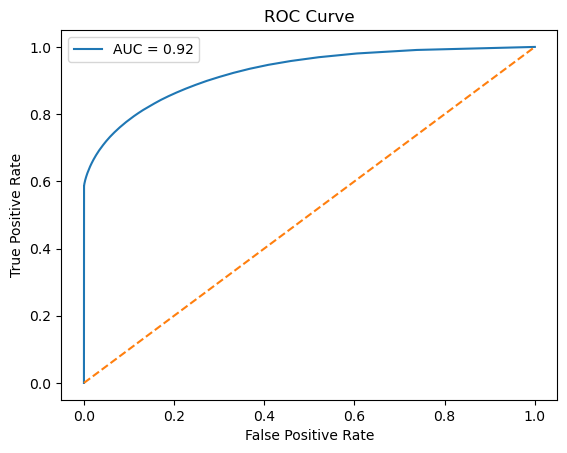

In [11]:
# ROC AUC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

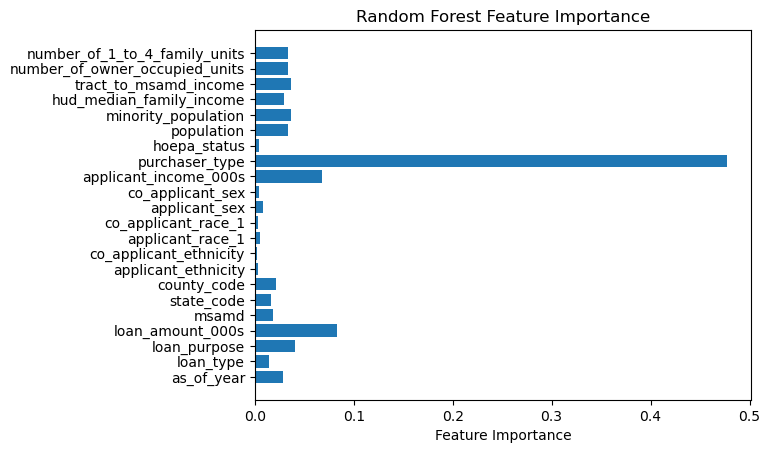

In [10]:
import matplotlib.pyplot as plt
importances = rf_model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()